# Machine Learning

#### Imports

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgbm

from datetime import datetime


import pickle

pd.set_option('display.max_columns', None)

## Carregar base de dados

In [2]:
PATH = '../data/processed/'

In [3]:
dataset = pd.read_csv(os.path.join(PATH, 'dataset2.csv'), sep=',')
print(dataset.shape)
dataset.head()

(4523, 59)


,BOM,RUIM,DESEMPENHO_ESC,CD_ESCOLA,CAPITAL,AREA,ESTIMATED_POP,RURAL_URBAN,GVA_PUBLIC,GDP_CAPITA,DEPENDENCIAS_SALAS_AULA,DEPENDENCIAS_TOT_SALA_LEITURA,DEPENDENCIAS_SALA_PROF,DEPENDENCIAS_LAB_INFO,DEPENDENCIAS_TOT_LAB_CIENCIA,FORMACAO_APERF/EXTENSIAOCULTURAL,FORMACAO_BACHARELADO/TECNIOLOGO,FORMACAO_DOUTORADO,FORMACAO_ENSINO_MEDIO,FORMACAO_ESPECIALIZACAO,FORMACAO_LICENCIATURA,FORMACAO_MESTRADO,FORMACAO_S/INFO,QTD_SERVIDORES,QTD_PROFESSORES,MEDIA_FORMACOES,QTD_FORMACAO_CONTINUADA,QTD_CARGOS_DISTINTOS,QTD_TOTAL_ALUNOS,QTD_CLASSES,MEDIA_ALUNOS_SALA,QTD_CLASSES_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_CLASSES_TIPO_ENSINO MEDIO,QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_ALUNOS_TIPO_ENSINO MEDIO,DIRETORES_QTD_2018,COORDENADORES_QTD_2018,DIRETORES_QTD_5_ANOS,COORDENADORES_QTD_5_ANOS,DIRETOR_IDADE,DIRETOR_CARGO_CLAS_EXER_IGUAIS,DIRETOR_ANOS_TRAB_CARGO_C,DIRETOR_ANOS_TRAB_CARGO_E,JORNADA_QTD_DISCIPLINAS_mean,JORNADA_QTD_DISCIPLINAS_max,JORNADA_QTD_TOTAL_AULAS_mean,JORNADA_QTD_TOTAL_AULAS_max,SERVIDORES_IDADE_mean,SERVIDORES_TEMPO_CARGO_C_mean,SERVIDORES_CAT_FUNCIONAL_A,SERVIDORES_CAT_FUNCIONAL_F,SERVIDORES_CAT_FUNCIONAL_N,SERVIDORES_CAT_FUNCIONAL_O,SERVIDORES_CAT_FUNCIONAL_P,MATEMATICA,LEITURA,ESCRITA,RELACAO_ALUNO_POR_SERVIDOR,RELACAO_ALUNO_POR_PROFESSOR
0,1.0,7.0,0,24,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,35,1,1,2,1,0.0,0.101695,0.008475,0.016949,0.016949,0.771186,0.084746,0.0,139,118,1.228814,13,6,2703,88,30.715909,34.0,40.0,956.0,1229.0,3.0,3.0,11.0,17.0,33.0,1,0.0,0.0,3.486726,10,48.849558,108,47.024096,10.819277,0.789157,0.144578,0.0,0.066265,0.0,4.0,3.0,4.0,19.446043,22.906780
1,0.0,4.0,0,36,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,21,1,1,2,1,0.0,0.095238,0.011905,0.000000,0.142857,0.738095,0.011905,0.0,92,84,1.297619,14,4,2164,69,31.362319,34.0,29.0,1189.0,945.0,4.0,3.0,13.0,13.0,50.0,0,18.0,0.0,2.975000,8,46.525000,104,45.460784,8.598039,0.754902,0.176471,0.0,0.068627,0.0,4.0,3.0,4.0,23.521739,25.761905
2,0.0,2.0,0,48,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,19,1,1,2,2,0.0,0.090909,0.018182,0.000000,0.018182,0.836364,0.036364,0.0,66,55,1.163636,4,5,1189,35,33.971429,0.0,35.0,0.0,1189.0,2.0,2.0,8.0,10.0,58.0,0,18.0,2.0,2.125000,4,44.375000,64,45.744681,9.361702,0.851064,0.106383,0.0,0.042553,0.0,4.0,3.0,4.0,18.015152,21.618182
3,0.0,2.0,0,59,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,11,1,1,1,1,0.0,0.093023,0.000000,0.000000,0.023256,0.813953,0.069767,0.0,49,43,1.209302,4,4,974,28,34.785714,0.0,28.0,0.0,974.0,4.0,1.0,12.0,6.0,38.0,0,10.0,0.0,2.150000,4,42.500000,98,42.972973,7.810811,0.783784,0.135135,0.0,0.081081,0.0,4.0,3.0,4.0,19.877551,22.651163
4,3.0,1.0,1,61,1,1521.11,12176866.0,Urbano,41902892.72,57071.43,15,1,1,1,0,0.0,0.039216,0.000000,0.098039,0.039216,0.803922,0.019608,0.0,59,51,1.078431,3,4,909,33,27.545455,30.0,0.0,897.0,0.0,2.0,2.0,10.0,8.0,53.0,1,9.0,9.0,2.488889,4,48.755556,64,47.955556,11.400000,0.600000,0.155556,0.0,0.244444,0.0,4.0,3.0,4.0,15.406780,17.823529


#### Remover a coluna de identificação *CD_ESCOLA* e os atributos *BOM* e *RUIM* que foram utilizados para construir a classe alvo
Cada linha representa uma escola, apesar da remoção de CD_ESCOLA, que é necessário já que este não é um atributo para predizer o desempenho escolar, é possível identificar o resultado da predição da escola com os índices do dataset, que permite localizar o *CD_ESCOLA* posteriormente

In [4]:
dataset.drop(['BOM', 'RUIM', 'CD_ESCOLA'], axis=1, inplace=True)

### Renomear a coluna *DESEMPENHO_ESC* para *DESEMPENHO*

In [5]:
dataset = dataset.rename(columns={'DESEMPENHO_ESC': 'DESEMPENHO'})

## Encodificação
Transformar os atributos categóricos para numéricos

### Transformar o atributo RURAL_URBAN para o tipo binario

- Urbano -> 1
- Intermediário Adjacente -> 0
- Rural Adjacente -> 0

In [6]:
dataset['RURAL_URBAN'].value_counts(normalize=True) * 100

Urbano                     90.470926
Rural Adjacente             5.328322
Intermediário Adjacente     4.200752
Name: RURAL_URBAN, dtype: float64

In [7]:
dataset['RURAL_URBAN'] = np.where(dataset['RURAL_URBAN'] == 'Urbano', 1, 0)

In [8]:
categorical_cols = ['CAPITAL', 'RURAL_URBAN', 'DIRETOR_CARGO_CLAS_EXER_IGUAIS']

In [9]:
def transform_categorical_cols(col, data):
    df_dummie = pd.get_dummies(data[col])
    df_dummie.columns = [col + '_' + str(int(c)) for c in df_dummie.columns]
    data = pd.concat([df_dummie, data.drop(col, axis=1)], axis=1)
    return data

In [10]:
for col in categorical_cols:
    dataset = transform_categorical_cols(col, dataset)

## Separacao dos dados
- Treinamento: 80%
- Teste: 20%

In [55]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('DESEMPENHO', axis=1), dataset['DESEMPENHO'], test_size=0.2, random_state=17)

## Normalização

In [27]:
scaler = MinMaxScaler()
cols = X_train.columns

scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_train, columns=cols)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [56]:
scaler = MinMaxScaler()
cols = X_train.columns

scaler.fit(X_train)
X_train.loc[:, cols] = scaler.transform(X_train)
X_test.loc[:, cols] = scaler.transform(X_test)
y_train.loc[:] = y_train.values
y_test.loc[:] = y_test.values

## Salvar dataset final

In [57]:
df_features = pd.concat([X_train, X_test])
df_features.loc[X_train.index, 'set_type'] = 'train'
df_features.loc[X_test.index, 'set_type'] = 'test'

In [58]:
df_targets = pd.concat([y_train, y_test])
df_targets = df_targets.rename('target')

In [59]:
df_final_dataset = pd.concat([df_features, df_targets], axis=1)

In [60]:
df_final_dataset = pd.concat([df_features, df_targets], axis=1)
df_final_dataset.sort_index(inplace=True)
df_final_dataset.to_csv('../data/processed/dataset_model.csv', index=False)

## Modeling

### Validação Cruzada com 10 folds

In [61]:
tree = DecisionTreeClassifier(random_state=17)
forest = RandomForestClassifier(random_state=17, n_jobs=-1)
gb = GradientBoostingClassifier(random_state=17)
lgb = lgbm.LGBMClassifier(random_state=17)
knn = KNeighborsClassifier()
mlp = MLPClassifier(random_state=17)
svm = SVC(kernel="linear", probability=True)

models = [tree, forest, gb, lgb, knn, mlp, svm]

In [62]:
kfold = KFold(n_splits=10, shuffle=True, random_state=17)

In [64]:
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

In [69]:
X_train

,DIRETOR_CARGO_CLAS_EXER_IGUAIS_0,DIRETOR_CARGO_CLAS_EXER_IGUAIS_1,RURAL_URBAN_0,RURAL_URBAN_1,CAPITAL_0,CAPITAL_1,AREA,ESTIMATED_POP,GVA_PUBLIC,GDP_CAPITA,DEPENDENCIAS_SALAS_AULA,DEPENDENCIAS_TOT_SALA_LEITURA,DEPENDENCIAS_SALA_PROF,DEPENDENCIAS_LAB_INFO,DEPENDENCIAS_TOT_LAB_CIENCIA,FORMACAO_APERF/EXTENSIAOCULTURAL,FORMACAO_BACHARELADO/TECNIOLOGO,FORMACAO_DOUTORADO,FORMACAO_ENSINO_MEDIO,FORMACAO_ESPECIALIZACAO,FORMACAO_LICENCIATURA,FORMACAO_MESTRADO,FORMACAO_S/INFO,QTD_SERVIDORES,QTD_PROFESSORES,MEDIA_FORMACOES,QTD_FORMACAO_CONTINUADA,QTD_CARGOS_DISTINTOS,QTD_TOTAL_ALUNOS,QTD_CLASSES,MEDIA_ALUNOS_SALA,QTD_CLASSES_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_CLASSES_TIPO_ENSINO MEDIO,QTD_ALUNOS_TIPO_ENSINO FUNDAMENTAL DE 9 ANOS,QTD_ALUNOS_TIPO_ENSINO MEDIO,DIRETORES_QTD_2018,COORDENADORES_QTD_2018,DIRETORES_QTD_5_ANOS,COORDENADORES_QTD_5_ANOS,DIRETOR_IDADE,DIRETOR_ANOS_TRAB_CARGO_C,DIRETOR_ANOS_TRAB_CARGO_E,JORNADA_QTD_DISCIPLINAS_mean,JORNADA_QTD_DISCIPLINAS_max,JORNADA_QTD_TOTAL_AULAS_mean,JORNADA_QTD_TOTAL_AULAS_max,SERVIDORES_IDADE_mean,SERVIDORES_TEMPO_CARGO_C_mean,SERVIDORES_CAT_FUNCIONAL_A,SERVIDORES_CAT_FUNCIONAL_F,SERVIDORES_CAT_FUNCIONAL_N,SERVIDORES_CAT_FUNCIONAL_O,SERVIDORES_CAT_FUNCIONAL_P,MATEMATICA,LEITURA,ESCRITA,RELACAO_ALUNO_POR_SERVIDOR,RELACAO_ALUNO_POR_PROFESSOR
0,0.0,1.0,0.0,1.0,1.0,0.0,0.162052,0.007977,0.000007,0.030555,0.06250,0.00,0.25,0.2,0.00,0.0,0.373626,0.000000,0.000000,0.148352,0.653846,0.000000,0.0,0.131944,0.117647,0.296703,0.107143,0.2,0.102389,0.107143,0.557025,0.150943,0.102041,0.112347,0.070750,0.285714,0.111111,0.421053,0.172414,0.204545,0.000000,0.000000,0.334448,0.333333,0.627339,0.478261,0.670444,0.361538,0.564103,0.153846,0.0,0.282051,0.0,1.0,0.75,0.8,0.305822,0.326529
1,1.0,0.0,0.0,1.0,1.0,0.0,0.104207,0.024096,0.022784,0.080887,0.21875,0.25,0.25,0.2,0.00,0.0,0.078341,0.000000,0.100806,0.414747,0.502304,0.000000,0.0,0.180556,0.154412,0.497696,0.357143,0.4,0.192264,0.250000,0.465120,0.377358,0.000000,0.315907,0.000000,0.285714,0.111111,0.578947,0.137931,0.613636,0.391304,0.043478,0.226087,0.111111,0.732432,0.478261,0.634151,0.466176,0.588235,0.147059,0.0,0.264706,0.0,1.0,0.75,0.8,0.458413,0.497432
2,1.0,0.0,0.0,1.0,1.0,0.0,0.258539,0.001521,0.000002,0.089564,0.50000,0.75,0.50,0.2,0.25,0.0,0.117040,0.000000,0.000000,0.139415,0.752151,0.126506,0.0,0.604167,0.536765,0.232358,0.428571,0.6,0.377323,0.416667,0.599707,0.358491,0.306122,0.337041,0.220169,0.142857,0.222222,0.684211,0.379310,0.704545,0.391304,0.000000,0.367316,0.333333,0.621855,0.913043,0.573704,0.420690,0.666667,0.103448,0.0,0.229885,0.0,1.0,0.75,0.8,0.317723,0.322229
3,0.0,1.0,0.0,1.0,1.0,0.0,0.161030,0.112080,0.115523,0.105339,0.21875,0.25,0.25,0.2,0.25,0.0,0.000000,0.000000,0.000000,0.037815,0.962185,0.000000,0.0,0.215278,0.176471,0.037815,0.035714,0.0,0.266591,0.273810,0.639795,0.358491,0.163265,0.292547,0.128300,0.428571,0.111111,0.578947,0.241379,0.386364,0.000000,0.000000,0.137300,0.222222,0.659673,0.739130,0.748650,0.462500,0.611111,0.333333,0.0,0.055556,0.0,1.0,0.75,0.8,0.560205,0.624477
4,1.0,0.0,0.0,1.0,0.0,1.0,0.000751,1.000000,1.000000,0.159826,0.40625,0.25,0.25,0.2,0.00,0.0,0.121429,0.000000,0.156250,0.032143,0.839286,0.000000,0.0,0.256944,0.220588,0.096429,0.035714,0.4,0.244975,0.273810,0.573489,0.509434,0.000000,0.395996,0.000000,0.285714,0.222222,0.684211,0.275862,0.613636,0.260870,0.000000,0.155280,0.111111,0.642857,0.478261,0.707130,0.375532,0.553191,0.382979,0.0,0.063830,0.0,1.0,0.75,0.8,0.444999,0.476414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,1.0,0.0,0.0,1.0,1.0,0.0,0.000169,0.007575,0.007903,0.100762,0.21875,0.25,0.25,0.2,0.00,0.0,0.260204,0.339286,0.000000,0.045918,0.724490,0.125000,0.0,0.159722,0.132353,0.275510,0.107143,0.6,0.153963,0.142857,0.671785,0.150943,0.163265,0.132369,0.123548,0.428571,0.111111,0.631579

In [73]:
results = []
scores_models1 = []
scores_models2 = []
for model in models:
    model_name = model.__class__.__name__
    auc_roc_scores_total = []
    acc_scores_total = []
    precision_scores_total = []
    recall_scores_total = []
    f1_scores_total = []
    
    start_time = datetime.now()
    
    for train_fold, test_fold in kfold.split(X_train):
        model.fit(X_train.loc[train_fold], y_train.loc[train_fold])
        pred = model.predict(X_train.loc[test_fold])  
        pred_scores = model.predict_proba(X_train.loc[test_fold])  
        
        auc_roc_scores = roc_auc_score(y_train.loc[test_fold], pred_scores[:, 1])
        acc_scores = accuracy_score(y_train.loc[test_fold], pred)
        precision_scores = precision_score(y_train.loc[test_fold], pred, average='macro')
        recall_scores = recall_score(y_train.loc[test_fold], pred, average='macro')
        f1_scores = f1_score(y_train.loc[test_fold], pred, average='macro')
        
        auc_roc_scores_total.append(auc_roc_scores)
        acc_scores_total.append(acc_scores)
        precision_scores_total.append(precision_scores)
        recall_scores_total.append(recall_scores)
        f1_scores_total.append(f1_scores)
    
    end_time = datetime.now() - start_time
    
    
    result_list = []
    result_list.append(model_name)
    result_list.extend(auc_roc_scores_total)
    scores_models1.append(result_list)
    
    results.append(
            {
                'MODEL': model_name,
                'AUC ROC': np.mean(auc_roc_scores_total),
                'ACCURACY': np.mean(acc_scores_total),
                'PRECISION': np.mean(precision_scores_total),
                'RECALL': np.mean(recall_scores_total),
                'F1-SCORE': np.mean(f1_scores_total),
                'TIME': end_time
            }
    )
df_results_2 = pd.DataFrame(results)
df_results_2

/home/milton/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/milton/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/milton/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/milton/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conver

,MODEL,AUC ROC,ACCURACY,PRECISION,RECALL,F1-SCORE,TIME
0,DecisionTreeClassifier,0.808430,0.891923,0.794003,0.808430,0.800396,0 days 00:00:00.559762
1,RandomForestClassifier,0.962036,0.922611,0.853087,0.861704,0.856302,0 days 00:00:04.849338
2,GradientBoostingClassifier,0.955285,0.919019,0.844352,0.862337,0.851992,0 days 00:00:16.511010
3,LGBMClassifier,0.959183,0.915427,0.841729,0.847231,0.843312,0 days 00:00:01.503457
4,KNeighborsClassifier,0.913774,0.905474,0.830290,0.806147,0.816166,0 days 00:00:01.085393
5,MLPClassifier,0.959665,0.914319,0.837528,0.852490,0.843164,0 days 00:00:54.133350
6,SVC,0.955100,0.922887,0.851174,0.873218,0.860620,0 days 00:00:07.550577


In [23]:
# OLD
df_results_2.round(3)

,MODEL,AUC ROC,ACCURACY,PRECISION,RECALL,F1-SCORE,TIME
0,DecisionTreeClassifier,0.798,0.890,0.790,NaN,0.794,0 days 00:00:00.516066
1,RandomForestClassifier,0.960,0.923,0.855,NaN,0.859,0 days 00:00:04.747651
2,GradientBoostingClassifier,0.955,0.919,0.845,NaN,0.852,0 days 00:00:17.153018
3,LGBMClassifier,0.959,0.915,0.842,NaN,0.843,0 days 00:00:01.201445
4,KNeighborsClassifier,0.914,0.905,0.830,NaN,0.816,0 days 00:00:01.143311
5,MLPClassifier,0.961,0.915,0.840,NaN,0.843,0 days 00:00:54.432778
6,SVC,0.955,0.924,0.852,NaN,0.862,0 days 00:00:07.058299


In [33]:
# NEW
df_results_2.round(3)

,MODEL,AUC ROC,ACCURACY,PRECISION,RECALL,F1-SCORE,TIME
0,DecisionTreeClassifier,0.808,0.892,0.794,NaN,0.800,0 days 00:00:00.521429
1,RandomForestClassifier,0.962,0.923,0.853,NaN,0.856,0 days 00:00:04.786130
2,GradientBoostingClassifier,0.955,0.919,0.844,NaN,0.852,0 days 00:00:17.781864
3,LGBMClassifier,0.959,0.915,0.842,NaN,0.843,0 days 00:00:01.303280
4,KNeighborsClassifier,0.914,0.905,0.830,NaN,0.816,0 days 00:00:01.011301
5,MLPClassifier,0.960,0.914,0.838,NaN,0.843,0 days 00:00:57.095674
6,SVC,0.955,0.923,0.851,NaN,0.861,0 days 00:00:07.015076


In [24]:
df_results_2.round(2)

,MODEL,AUC ROC,ACCURACY,PRECISION,RECALL,F1-SCORE,TIME
0,DecisionTreeClassifier,0.80,0.89,0.79,NaN,0.79,0 days 00:00:00.516066
1,RandomForestClassifier,0.96,0.92,0.85,NaN,0.86,0 days 00:00:04.747651
2,GradientBoostingClassifier,0.95,0.92,0.84,NaN,0.85,0 days 00:00:17.153018
3,LGBMClassifier,0.96,0.92,0.84,NaN,0.84,0 days 00:00:01.201445
4,KNeighborsClassifier,0.91,0.91,0.83,NaN,0.82,0 days 00:00:01.143311
5,MLPClassifier,0.96,0.91,0.84,NaN,0.84,0 days 00:00:54.432778
6,SVC,0.96,0.92,0.85,NaN,0.86,0 days 00:00:07.058299


In [75]:
# NEW
df_results_2.round(3)

,MODEL,AUC ROC,ACCURACY,PRECISION,RECALL,F1-SCORE,TIME
0,DecisionTreeClassifier,0.808,0.892,0.794,0.808,0.800,0 days 00:00:00.559762
1,RandomForestClassifier,0.962,0.923,0.853,0.862,0.856,0 days 00:00:04.849338
2,GradientBoostingClassifier,0.955,0.919,0.844,0.862,0.852,0 days 00:00:16.511010
3,LGBMClassifier,0.959,0.915,0.842,0.847,0.843,0 days 00:00:01.503457
4,KNeighborsClassifier,0.914,0.905,0.830,0.806,0.816,0 days 00:00:01.085393
5,MLPClassifier,0.960,0.914,0.838,0.852,0.843,0 days 00:00:54.133350
6,SVC,0.955,0.923,0.851,0.873,0.861,0 days 00:00:07.550577


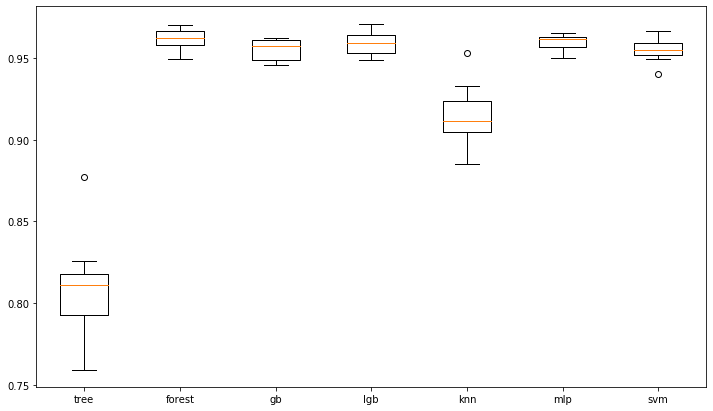

In [76]:
scores_df_auc_roc = pd.DataFrame(scores_models1)
scores_df_auc_roc = scores_df_auc_roc.set_index(0)
scores_df_auc_roc.name = "MODEL"

fig, ax = plt.subplots(figsize=(12,7))

ax.boxplot(scores_df_auc_roc)
plt.xticks(list(range(1,8)), ['tree', 'forest', 'gb', 'lgb', 'knn', 'mlp', 'svm'])
plt.show()

### Teste estatístico

In [44]:
from scipy.stats import kruskal, friedmanchisquare
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

In [45]:
scores_lists = [df.tolist() for i, df in scores_df_auc_roc.iterrows()]

In [46]:
stat, p = kruskal(*scores_lists)
print(stat, p)
alpha = 0.05
if p > alpha:
    print('Distribuições iguais (falha em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeita H0)')

46.199275653923564 2.702047086607649e-08
Distribuições diferentes (rejeita H0)


In [47]:
scores_lists = [df.tolist() for i, df in scores_df_auc_roc.drop(['DecisionTreeClassifier', 'KNeighborsClassifier']).iterrows()]

In [48]:
stat, p = kruskal(*scores_lists)
print(stat, p)
alpha = 0.05

if p > alpha:
    print('Distribuições iguais (falha em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeita H0)')

8.13929411764704 0.08660689416490826
Distribuições iguais (falha em rejeitar H0)


In [49]:
stat, p = friedmanchisquare(*scores_lists)
print(stat, p)
alpha = 0.05

if p > alpha:
    print('Distribuições iguais (falha em rejeitar H0)')
else:
    print('Distribuições diferentes (rejeita H0)')

13.039999999999992 0.011081991649702081
Distribuições diferentes (rejeita H0)


In [ ]:
friedmanchisquare

### Avaliação no conjunto de teste

In [50]:
model = lgbm.LGBMClassifier(random_state=17)
model.fit(X_train_norm, y_train)
pred = model.predict(X_test_norm)
pred_scores = model.predict_proba(X_test_norm)[:, 1]

In [51]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16

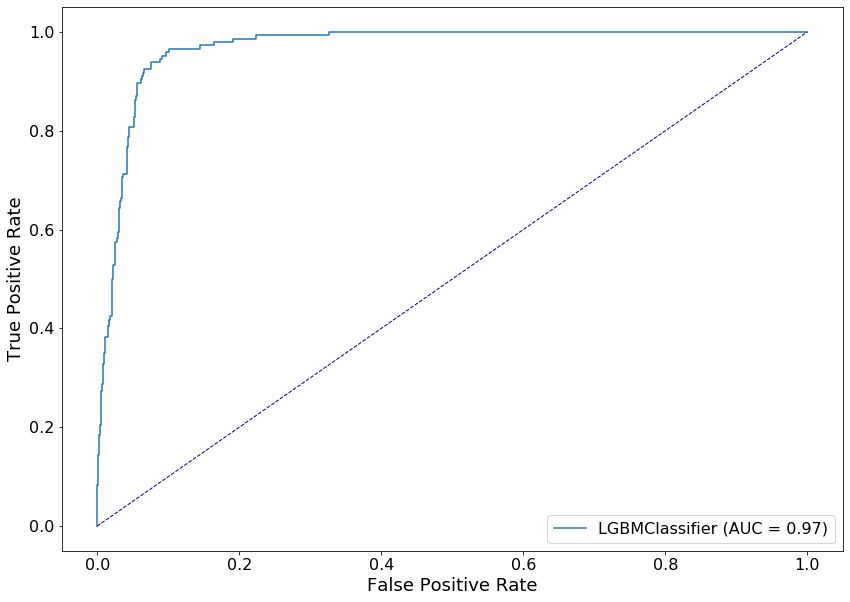

In [52]:
from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(14,10))
plot_roc_curve(model, X_test_norm, y_test, ax=ax)
ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
plt.show()

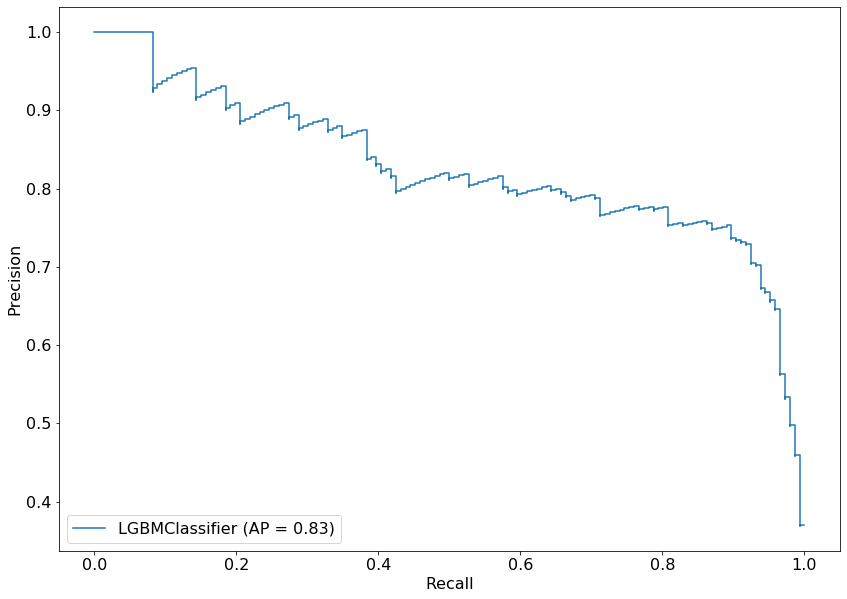

In [53]:
from sklearn.metrics import plot_precision_recall_curve
fig, ax = plt.subplots(figsize=(14,10))
plot_precision_recall_curve(model, X_test_norm, y_test, ax=ax)

In [54]:
print('Acc score:', accuracy_score(y_test, pred))
print('Recall score:', recall_score(y_test, pred))
print('Recall score (binary):', recall_score(y_test, pred, average='binary'))
print('Recall score (macro):', recall_score(y_test, pred, average='macro'))
print('Recall score (weighted):', recall_score(y_test, pred, average='weighted'))
recall_score(y_test, pred, average=None)

Acc score: 0.932596685082873
Recall score: 0.8698630136986302
Recall score (binary): 0.8698630136986302
Recall score (macro): 0.9072635226595918
Recall score (weighted): 0.932596685082873


array([0.94466403, 0.86986301])

Acc score: 0.932596685082873
F1 score: 0.8063492063492064
AUC ROC: 0.9684516396845163


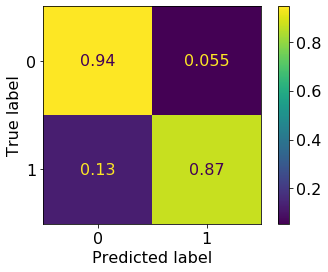

In [55]:
print('Acc score:', accuracy_score(y_test, pred))
print('F1 score:', f1_score(y_test, pred))
print('AUC ROC:', roc_auc_score(y_test, pred_scores))
plot_confusion_matrix(model, X_test_norm, y_test, normalize='true')

## Exportar modelo

In [56]:
with open('../models/model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Conjunto de dados completo (final)

In [ ]:
dataset

In [28]:
dataset.to_csv('../data/processed/dataset_final.csv', index=False)